In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 5987
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  P48467O7_00_21_11
NN-MODEL FILENAME:  ./models/P48467O7_00_21_11_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1265.95 MiB, increment: 1045.69 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   14199
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 69
TOTAL SERIAL TIMESTEPS:   14199
TOTAL PARALLEL TIMESTEPS: 69


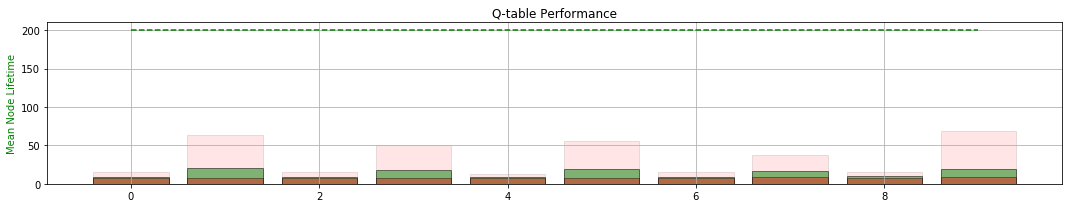

MEMORY COUNTER:  14199
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 598.029	LOSS : 567.644	LOSS : 523.392	LOSS : 521.420	LOSS : 501.534	LOSS : 503.071	LOSS : 515.693	LOSS : 491.726	LOSS : 492.136	LOSS : 478.887	LOSS : 484.557	LOSS : 482.014	LOSS : 444.048	LOSS : 448.901	LOSS : 444.382	LOSS : 459.781	LOSS : 449.526	LOSS : 439.116	LOSS : 440.223	LOSS : 422.923	
Validating... MEAN TIME:  130.585
LOSS : 428.321	LOSS : 394.059	LOSS : 420.435	LOSS : 421.495	LOSS : 393.731	LOSS : 406.091	LOSS : 392.847	LOSS : 389.416	LOSS : 402.652	LOSS : 405.087	LOSS : 386.879	LOSS : 405.406	LOSS : 384.664	LOSS : 398.557	LOSS : 381.404	LOSS : 398.661	LOSS : 383.677	LOSS : 388.197	LOSS : 398.133	LOSS : 384.988	
Validating... MEAN TIME:  121.285
LOSS : 394.461	LOSS : 386.890	LOSS : 393.870	LOSS : 406.555	LOSS : 394.141	LOSS : 388.488	LOSS : 395.368	LOSS : 403.141	LOSS : 405.667	LOSS : 414.758	LOSS : 414.199	LOSS : 401.303	LOSS : 409.433	LOSS : 417.345	LOSS : 420.326	LOSS : 421.441	LOSS : 4

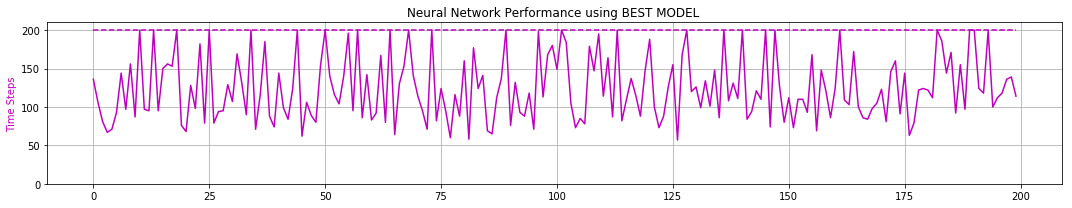

peak memory: 1318.80 MiB, increment: 1041.61 MiB
0 -max- [ 0.050  0.195  0.209  2.966]
0 -min- [-0.216 -2.000 -0.068 -0.373]

1 -max- [ 0.695  2.276  0.209  1.704]
1 -min- [-0.173 -1.016 -0.209 -2.743]

2 -max- [ 0.056  0.192  0.209  2.965]
2 -min- [-0.194 -1.989 -0.063 -0.343]

3 -max- [ 0.495  2.720  0.208  2.440]
3 -min- [-0.178 -1.601 -0.209 -2.822]

4 -max- [ 0.049  0.234  0.209  2.963]
4 -min- [-0.191 -1.991 -0.055 -0.286]

5 -max- [ 0.557  2.076  0.208  2.138]
5 -min- [-0.204 -1.391 -0.209 -2.737]

6 -max- [ 0.051  0.234  0.209  2.963]
6 -min- [-0.206 -1.998 -0.061 -0.339]

7 -max- [ 0.338  1.989  0.209  2.223]
7 -min- [-0.197 -1.398 -0.209 -2.931]

8 -max- [ 0.046  0.167  0.209  2.967]
8 -min- [-0.211 -1.993 -0.065 -0.346]

9 -max- [ 0.527  2.464  0.209  2.268]
9 -min- [-0.157 -1.329 -0.209 -2.769]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   35823
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 130
TOTAL SERIAL TIMESTEPS:   50022
TOTAL PARALLEL TIMES

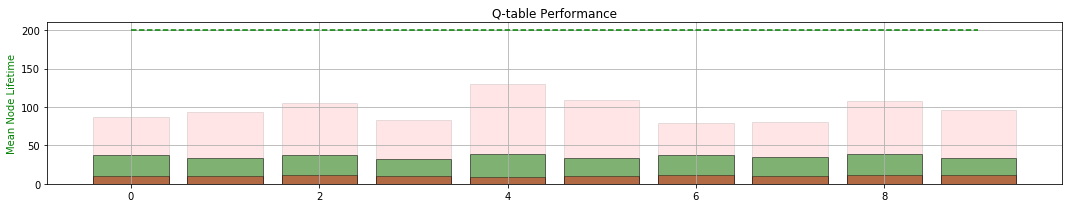

MEMORY COUNTER:  50022
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 978.146	LOSS : 969.105	LOSS : 883.282	LOSS : 827.266	LOSS : 763.095	LOSS : 791.071	LOSS : 735.369	LOSS : 668.148	LOSS : 675.893	LOSS : 642.536	LOSS : 622.697	LOSS : 602.811	LOSS : 585.137	LOSS : 562.543	LOSS : 556.288	LOSS : 512.204	LOSS : 514.551	LOSS : 514.442	LOSS : 511.177	LOSS : 485.246	
Validating... MEAN TIME:  122.28
LOSS : 486.594	LOSS : 488.581	LOSS : 482.702	LOSS : 500.968	LOSS : 487.916	LOSS : 475.786	LOSS : 492.362	LOSS : 482.873	LOSS : 514.069	LOSS : 503.306	LOSS : 473.723	LOSS : 483.763	LOSS : 466.856	LOSS : 472.322	LOSS : 488.861	LOSS : 514.888	LOSS : 497.126	LOSS : 516.000	LOSS : 479.321	LOSS : 493.236	
Validating... MEAN TIME:  150.955
LOSS : 520.542	LOSS : 483.351	LOSS : 543.618	LOSS : 544.135	LOSS : 522.620	LOSS : 526.774	LOSS : 583.677	LOSS : 547.864	LOSS : 558.295	LOSS : 574.905	LOSS : 596.181	LOSS : 590.390	LOSS : 559.594	LOSS : 574.421	LOSS : 581.306	LOSS : 587.058	LOSS : 58

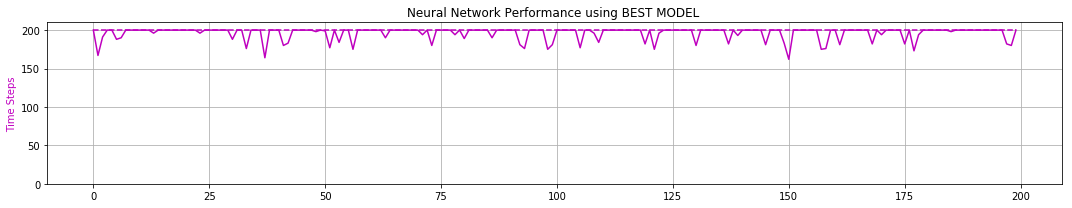

peak memory: 1365.30 MiB, increment: 1046.18 MiB
0 -max- [ 0.364  1.102  0.209  2.395]
0 -min- [-0.378 -1.577 -0.058 -0.664]

1 -max- [ 0.260  1.412  0.050  0.707]
1 -min- [-0.402 -1.144 -0.209 -2.191]

2 -max- [ 0.326  1.138  0.209  2.174]
2 -min- [-0.220 -1.404 -0.050 -0.603]

3 -max- [ 0.240  1.767  0.050  0.676]
3 -min- [-0.405 -1.302 -0.209 -2.694]

4 -max- [ 0.305  1.109  0.209  2.353]
4 -min- [-0.316 -1.597 -0.050 -0.715]

5 -max- [ 0.671  1.574  0.208  0.708]
5 -min- [-0.398 -1.256 -0.209 -2.358]

6 -max- [ 0.322  1.070  0.209  2.384]
6 -min- [-0.247 -1.548 -0.050 -0.673]

7 -max- [ 0.233  1.418  0.049  0.688]
7 -min- [-0.363 -1.288 -0.209 -2.401]

8 -max- [ 0.406  1.141  0.209  2.372]
8 -min- [-0.287 -1.565 -0.051 -0.692]

9 -max- [ 0.234  1.584  0.050  0.682]
9 -min- [-0.389 -1.320 -0.209 -2.329]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   119867
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   169889
TOTAL PARALLEL TIM

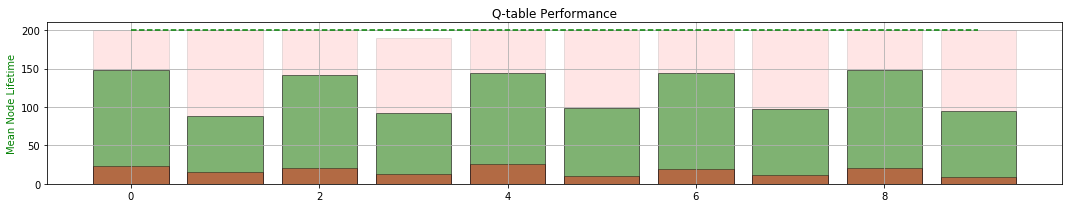

MEMORY COUNTER:  169889
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 1236.384	LOSS : 1107.368	LOSS : 1077.269	LOSS : 960.320	LOSS : 966.169	LOSS : 827.486	LOSS : 776.840	LOSS : 729.683	LOSS : 664.157	LOSS : 652.639	LOSS : 573.528	LOSS : 561.006	LOSS : 508.846	LOSS : 486.179	LOSS : 501.697	LOSS : 459.795	LOSS : 454.089	LOSS : 439.146	LOSS : 422.826	LOSS : 419.312	
Validating... MEAN TIME:  130.86
LOSS : 381.728	LOSS : 361.103	LOSS : 347.525	LOSS : 355.150	LOSS : 374.132	LOSS : 357.873	LOSS : 332.708	LOSS : 331.877	LOSS : 340.840	LOSS : 322.362	LOSS : 336.274	LOSS : 309.943	LOSS : 300.928	LOSS : 327.243	LOSS : 297.351	LOSS : 317.831	LOSS : 331.650	LOSS : 318.513	LOSS : 305.330	LOSS : 315.125	
Validating... MEAN TIME:  169.56
LOSS : 314.369	LOSS : 316.524	LOSS : 317.969	LOSS : 321.432	LOSS : 302.634	LOSS : 326.177	LOSS : 354.206	LOSS : 323.661	LOSS : 321.610	LOSS : 301.951	LOSS : 354.222	LOSS : 327.039	LOSS : 310.507	LOSS : 317.090	LOSS : 334.047	LOSS : 338.749	LOSS :

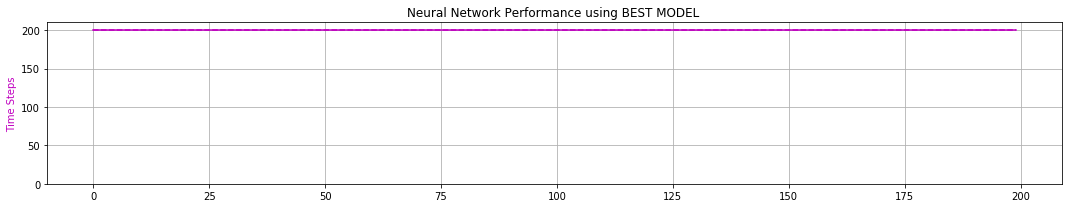

peak memory: 1425.53 MiB, increment: 1037.03 MiB
0 -max- [ 2.378  2.441  0.208  2.174]
0 -min- [-1.622 -2.234 -0.209 -2.135]

1 -max- [ 2.298  2.051  0.190  1.303]
1 -min- [-1.333 -1.856 -0.209 -2.333]

2 -max- [ 2.382  2.444  0.209  2.228]
2 -min- [-1.660 -2.249 -0.209 -2.140]

3 -max- [ 0.161  1.194  0.088  1.320]
3 -min- [-1.302 -1.873 -0.209 -2.185]

4 -max- [ 2.383  2.459  0.209  2.568]
4 -min- [-1.406 -2.045 -0.209 -2.193]

5 -max- [ 2.230  2.038  0.184  1.309]
5 -min- [-1.298 -1.844 -0.209 -2.225]

6 -max- [ 2.374  2.664  0.209  2.272]
6 -min- [-1.364 -1.849 -0.209 -2.171]

7 -max- [ 1.375  1.908  0.157  1.309]
7 -min- [-1.332 -1.867 -0.209 -1.940]

8 -max- [ 2.385  2.669  0.209  2.332]
8 -min- [-1.452 -2.051 -0.209 -2.215]

9 -max- [ 0.236  1.207  0.097  1.312]
9 -min- [-1.309 -1.869 -0.209 -2.066]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   162997
SMALLEST TIMESTEP: 48
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   332886
TOTAL PARALLEL TI

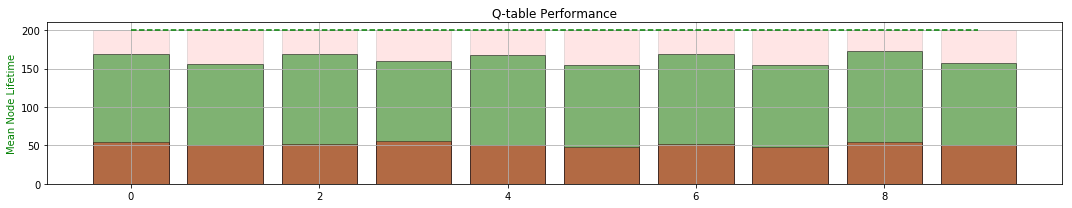

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 375.826	LOSS : 281.414	LOSS : 289.774	LOSS : 263.277	LOSS : 221.070	LOSS : 187.581	LOSS : 159.063	LOSS : 153.214	LOSS : 155.494	LOSS : 128.489	LOSS : 118.005	LOSS : 111.499	LOSS : 111.534	LOSS : 101.098	LOSS : 95.952	LOSS : 105.513	LOSS : 94.212	LOSS : 91.645	LOSS : 89.901	LOSS : 97.251	
Validating... MEAN TIME:  163.375
LOSS : 102.329	LOSS : 102.407	LOSS : 87.620	LOSS : 90.846	LOSS : 88.513	LOSS : 87.006	LOSS : 95.875	LOSS : 85.203	LOSS : 79.740	LOSS : 93.360	LOSS : 83.064	LOSS : 89.269	LOSS : 91.009	LOSS : 89.751	LOSS : 88.229	LOSS : 76.962	LOSS : 79.299	LOSS : 75.187	LOSS : 69.513	LOSS : 65.090	
Validating... MEAN TIME:  199.83
LOSS : 77.469	LOSS : 76.634	LOSS : 73.689	LOSS : 81.966	LOSS : 80.464	LOSS : 85.314	LOSS : 75.315	LOSS : 88.936	LOSS : 80.290	LOSS : 82.827	LOSS : 75.454	LOSS : 84.027	LOSS : 85.264	LOSS : 76.713	LOSS : 79.792	LOSS : 89.937	LOSS : 84.128	LOSS : 89.824	LOSS : 74.964	LOSS 

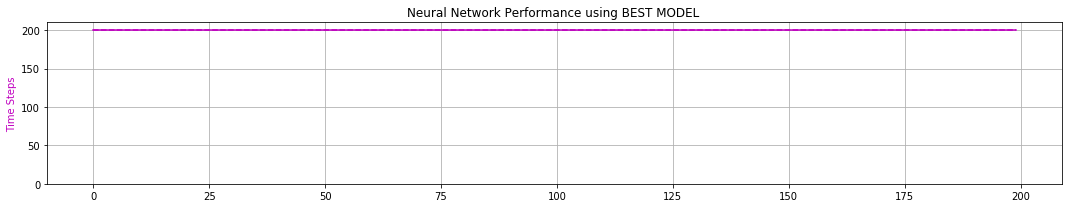

peak memory: 1467.81 MiB, increment: 1053.18 MiB
0 -max- [ 0.227  1.750  0.178  1.622]
0 -min- [-1.280 -1.514 -0.209 -2.259]

1 -max- [ 0.199  1.597  0.150  1.318]
1 -min- [-2.027 -1.646 -0.209 -2.273]

2 -max- [ 0.188  1.782  0.169  1.580]
2 -min- [-1.556 -1.377 -0.209 -2.278]

3 -max- [ 0.170  1.738  0.145  1.315]
3 -min- [-1.922 -1.493 -0.209 -2.486]

4 -max- [ 0.224  1.733  0.161  1.577]
4 -min- [-1.289 -1.374 -0.209 -2.216]

5 -max- [ 0.157  1.785  0.150  1.318]
5 -min- [-1.779 -1.466 -0.209 -2.418]

6 -max- [ 0.272  1.754  0.206  1.326]
6 -min- [-1.455 -1.550 -0.209 -2.246]

7 -max- [ 0.161  1.600  0.148  1.319]
7 -min- [-1.958 -1.453 -0.209 -2.210]

8 -max- [ 0.262  1.872  0.189  1.702]
8 -min- [-1.310 -1.538 -0.209 -2.267]

9 -max- [ 0.209  1.595  0.149  1.327]
9 -min- [-1.944 -1.471 -0.209 -2.244]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   145275
SMALLEST TIMESTEP: 13
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   478161
TOTAL PARALLEL TI

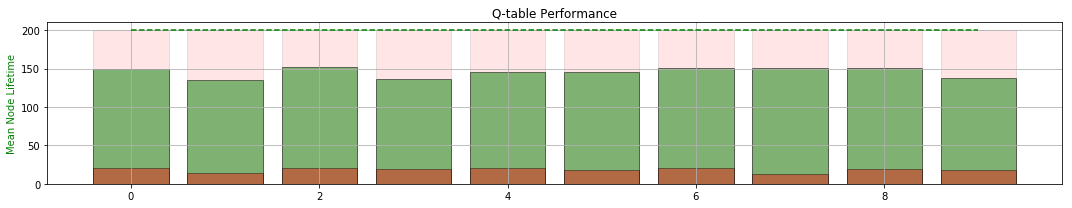

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 91.923	LOSS : 116.138	LOSS : 102.911	LOSS : 90.656	LOSS : 96.806	LOSS : 81.675	LOSS : 77.067	LOSS : 64.164	LOSS : 73.649	LOSS : 72.552	LOSS : 67.042	LOSS : 87.729	LOSS : 72.935	LOSS : 79.798	LOSS : 70.656	LOSS : 59.774	LOSS : 72.785	LOSS : 75.021	LOSS : 66.578	LOSS : 57.605	
Validating... MEAN TIME:  169.745
LOSS : 72.747	LOSS : 67.190	LOSS : 70.994	LOSS : 69.807	LOSS : 71.610	LOSS : 68.342	LOSS : 73.893	LOSS : 79.226	LOSS : 74.334	LOSS : 68.090	LOSS : 71.667	LOSS : 69.513	LOSS : 68.042	LOSS : 69.684	LOSS : 71.892	LOSS : 76.318	LOSS : 79.905	LOSS : 74.396	LOSS : 68.275	LOSS : 72.527	
Validating... MEAN TIME:  152.055
LOSS : 66.142	LOSS : 82.284	LOSS : 66.147	LOSS : 71.292	LOSS : 63.901	LOSS : 62.939	LOSS : 63.517	LOSS : 77.520	LOSS : 71.003	LOSS : 72.143	LOSS : 73.703	LOSS : 81.839	LOSS : 77.122	LOSS : 64.844	LOSS : 60.911	LOSS : 65.483	LOSS : 62.546	LOSS : 70.213	LOSS : 73.059	LOSS : 62.366	
Vali

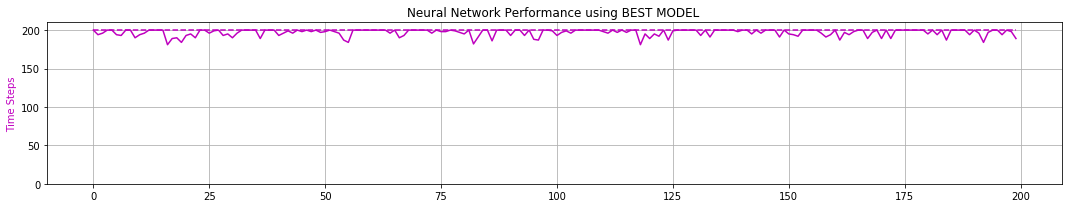

peak memory: 1479.01 MiB, increment: 984.21 MiB
0 -max- [ 0.185  1.376  0.202  1.863]
0 -min- [-2.398 -2.130 -0.209 -2.126]

1 -max- [ 0.165  1.407  0.171  1.635]
1 -min- [-2.399 -1.939 -0.209 -2.139]

2 -max- [ 0.195  1.549  0.200  1.825]
2 -min- [-2.396 -2.102 -0.209 -2.172]

3 -max- [ 0.188  1.397  0.178  1.630]
3 -min- [-2.398 -1.938 -0.209 -2.104]

4 -max- [ 0.156  1.584  0.209  1.812]
4 -min- [-2.399 -2.086 -0.209 -2.128]

5 -max- [ 0.170  1.388  0.176  1.634]
5 -min- [-2.399 -2.036 -0.209 -2.132]

6 -max- [ 0.183  1.407  0.209  1.881]
6 -min- [-2.398 -2.084 -0.209 -2.135]

7 -max- [ 0.161  1.205  0.178  1.638]
7 -min- [-2.398 -1.938 -0.209 -1.906]

8 -max- [ 0.203  1.400  0.208  1.786]
8 -min- [-2.399 -1.946 -0.209 -2.113]

9 -max- [ 0.196  1.544  0.176  1.631]
9 -min- [-2.400 -1.924 -0.209 -2.323]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   104236
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 148
TOTAL SERIAL TIMESTEPS:   582397
TOTAL PARALLEL TIM

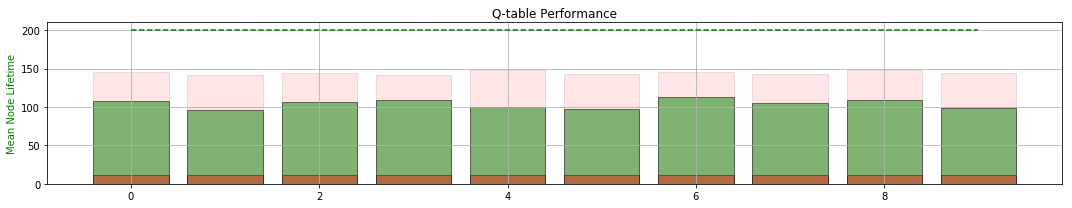

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.182	LOSS : 97.154	LOSS : 89.137	LOSS : 86.115	LOSS : 93.782	LOSS : 74.282	LOSS : 87.724	LOSS : 75.662	LOSS : 102.466	LOSS : 108.055	LOSS : 87.931	LOSS : 99.765	LOSS : 77.144	LOSS : 73.674	LOSS : 103.373	LOSS : 86.175	LOSS : 96.127	LOSS : 81.392	LOSS : 88.436	LOSS : 96.397	
Validating... MEAN TIME:  200.0
LOSS : 89.351	LOSS : 84.018	LOSS : 82.203	LOSS : 83.711	LOSS : 80.430	LOSS : 79.358	LOSS : 79.789	LOSS : 92.060	LOSS : 96.770	LOSS : 86.235	LOSS : 83.982	LOSS : 81.576	LOSS : 86.357	LOSS : 79.488	LOSS : 101.001	LOSS : 92.242	LOSS : 82.854	LOSS : 84.977	LOSS : 77.010	LOSS : 77.169	
Validating... MEAN TIME:  129.59
LOSS : 83.143	LOSS : 96.530	LOSS : 80.932	LOSS : 75.927	LOSS : 88.388	LOSS : 86.662	LOSS : 83.504	LOSS : 79.643	LOSS : 67.578	LOSS : 67.086	LOSS : 82.082	LOSS : 71.986	LOSS : 84.161	LOSS : 87.378	LOSS : 87.759	LOSS : 78.994	LOSS : 88.420	LOSS : 82.731	LOSS : 84.808	LOSS : 90.994	
Valid

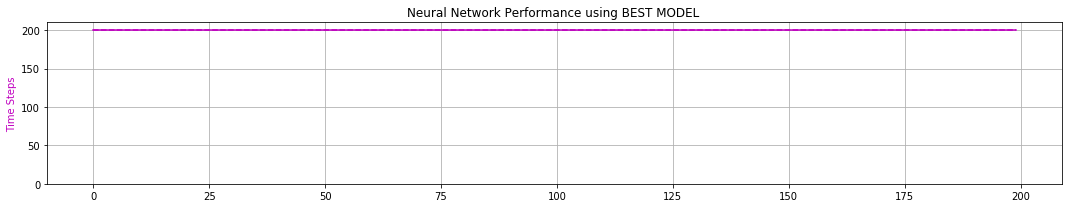

peak memory: 1493.31 MiB, increment: 978.73 MiB
0 -max- [ 0.206  1.395  0.079  1.227]
0 -min- [-2.400 -2.064 -0.209 -1.975]

1 -max- [ 0.224  1.399  0.060  1.010]
1 -min- [-2.398 -2.169 -0.209 -1.966]

2 -max- [ 0.217  1.390  0.072  1.071]
2 -min- [-2.398 -2.259 -0.209 -1.959]

3 -max- [ 0.181  1.376  0.060  1.006]
3 -min- [-2.400 -2.171 -0.209 -1.955]

4 -max- [ 0.204  1.408  0.082  1.100]
4 -min- [-2.400 -2.062 -0.209 -1.973]

5 -max- [ 0.216  1.409  0.065  1.007]
5 -min- [-2.400 -2.045 -0.209 -1.974]

6 -max- [ 0.194  1.414  0.084  1.027]
6 -min- [-2.399 -2.067 -0.209 -1.976]

7 -max- [ 0.222  1.380  0.059  1.214]
7 -min- [-2.400 -2.163 -0.209 -1.975]

8 -max- [ 0.216  1.380  0.081  1.100]
8 -min- [-2.399 -2.163 -0.209 -1.975]

9 -max- [ 0.196  1.398  0.059  0.999]
9 -min- [-2.400 -2.426 -0.209 -1.975]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   65824
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   648221
TOTAL PARALLEL TIME

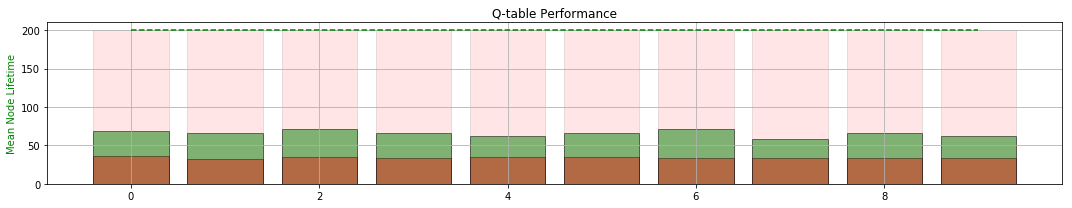

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.049	LOSS : 98.818	LOSS : 111.116	LOSS : 100.976	LOSS : 108.699	LOSS : 106.381	LOSS : 101.865	LOSS : 99.173	LOSS : 105.692	LOSS : 108.625	LOSS : 102.122	LOSS : 96.075	LOSS : 104.413	LOSS : 109.311	LOSS : 103.433	LOSS : 94.523	LOSS : 103.876	LOSS : 104.475	LOSS : 106.884	LOSS : 99.755	
Validating... MEAN TIME:  174.54
LOSS : 98.148	LOSS : 113.163	LOSS : 114.594	LOSS : 106.246	LOSS : 103.148	LOSS : 99.064	LOSS : 116.622	LOSS : 108.482	LOSS : 102.599	LOSS : 97.842	LOSS : 100.685	LOSS : 97.721	LOSS : 100.361	LOSS : 105.632	LOSS : 109.487	LOSS : 91.293	LOSS : 106.516	LOSS : 114.310	LOSS : 101.036	LOSS : 110.084	
Validating... MEAN TIME:  107.735
LOSS : 104.404	LOSS : 99.375	LOSS : 95.105	LOSS : 111.066	LOSS : 103.665	LOSS : 97.678	LOSS : 99.465	LOSS : 112.417	LOSS : 97.359	LOSS : 88.524	LOSS : 91.869	LOSS : 97.984	LOSS : 100.108	LOSS : 89.286	LOSS : 95.486	LOSS : 101.787	LOSS : 113.378	LOSS : 98.681	

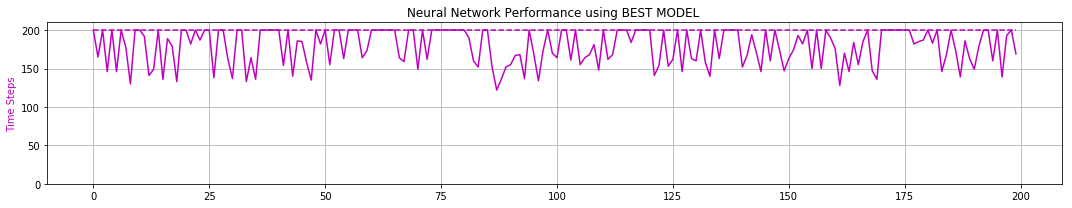

peak memory: 1454.44 MiB, increment: 1015.61 MiB
0 -max- [ 0.592  2.287  0.208  1.527]
0 -min- [-1.201 -1.626 -0.209 -2.276]

1 -max- [ 0.580  2.277  0.163  1.306]
1 -min- [-0.371 -1.009 -0.209 -2.281]

2 -max- [ 0.656  2.290  0.191  1.472]
2 -min- [-2.400 -2.711 -0.209 -2.277]

3 -max- [ 0.590  2.295  0.164  1.367]
3 -min- [-2.381 -2.890 -0.209 -2.283]

4 -max- [ 0.593  2.284  0.188  1.533]
4 -min- [-0.532 -1.089 -0.209 -2.277]

5 -max- [ 0.565  2.304  0.165  1.304]
5 -min- [-2.357 -2.707 -0.209 -2.338]

6 -max- [ 0.616  2.288  0.177  1.316]
6 -min- [-0.316 -1.176 -0.209 -2.282]

7 -max- [ 0.571  2.290  0.164  1.306]
7 -min- [-0.173 -0.983 -0.209 -2.430]

8 -max- [ 0.664  2.412  0.208  1.313]
8 -min- [-0.331 -1.185 -0.209 -2.281]

9 -max- [ 0.567  2.273  0.165  1.309]
9 -min- [-1.261 -1.787 -0.209 -2.319]

Quantization TIME:  0.01 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   147563
SMALLEST TIMESTEP: 84
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   795784
TOTAL PARALLEL TI

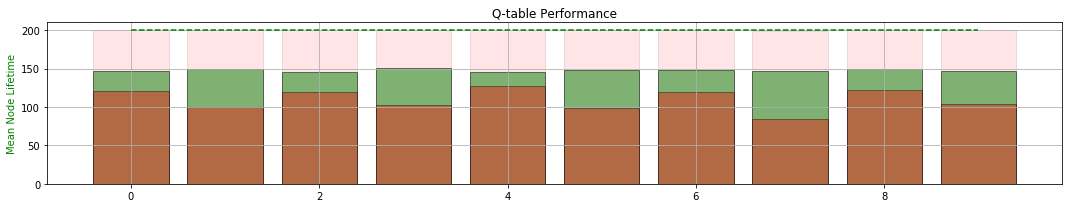

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 89.960	LOSS : 90.529	LOSS : 88.285	LOSS : 89.421	LOSS : 85.101	LOSS : 88.633	LOSS : 70.416	LOSS : 79.244	LOSS : 84.933	LOSS : 88.547	LOSS : 83.471	LOSS : 84.367	LOSS : 76.276	LOSS : 81.331	LOSS : 103.835	LOSS : 88.253	LOSS : 82.687	LOSS : 88.666	LOSS : 98.062	LOSS : 94.911	
Validating... MEAN TIME:  93.695
LOSS : 87.909	LOSS : 91.277	LOSS : 89.798	LOSS : 74.956	LOSS : 77.808	LOSS : 103.509	LOSS : 101.667	LOSS : 99.506	LOSS : 94.740	LOSS : 87.844	LOSS : 87.003	LOSS : 106.964	LOSS : 94.774	LOSS : 99.351	LOSS : 98.054	LOSS : 95.463	LOSS : 100.778	LOSS : 92.003	LOSS : 82.387	LOSS : 90.796	
Validating... MEAN TIME:  97.655
LOSS : 87.873	LOSS : 80.422	LOSS : 95.298	LOSS : 88.717	LOSS : 87.666	LOSS : 99.646	LOSS : 91.734	LOSS : 91.136	LOSS : 84.594	LOSS : 86.338	LOSS : 88.930	LOSS : 88.717	LOSS : 84.843	LOSS : 80.945	LOSS : 88.713	LOSS : 83.899	LOSS : 81.181	LOSS : 96.351	LOSS : 80.075	LOSS : 90.005	
Val

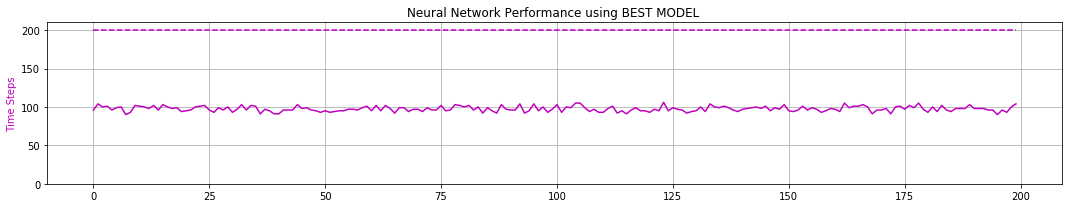

peak memory: 1452.99 MiB, increment: 1036.95 MiB
0 -max- [ 2.400  2.759  0.194  1.093]
0 -min- [-2.400 -2.904 -0.200 -1.273]

1 -max- [ 2.399  2.436  0.139  0.896]
1 -min- [-2.400 -2.983 -0.209 -1.191]

2 -max- [ 2.399  2.786  0.198  0.873]
2 -min- [-2.396 -2.965 -0.206 -1.210]

3 -max- [ 2.399  2.391  0.138  0.764]
3 -min- [-2.400 -3.170 -0.209 -0.923]

4 -max- [ 2.400  2.590  0.191  1.078]
4 -min- [-2.395 -2.971 -0.207 -0.930]

5 -max- [ 2.399  2.410  0.136  0.736]
5 -min- [-2.395 -2.988 -0.207 -0.943]

6 -max- [ 2.400  2.423  0.180  1.097]
6 -min- [-2.397 -2.979 -0.202 -0.912]

7 -max- [ 2.399  2.627  0.139  0.754]
7 -min- [-2.397 -3.086 -0.207 -0.872]

8 -max- [ 2.400  2.415  0.153  0.788]
8 -min- [-2.397 -3.151 -0.202 -0.714]

9 -max- [ 2.400  2.593  0.138  0.711]
9 -min- [-2.398 -3.073 -0.209 -0.876]

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   44615
SMALLEST TIMESTEP: 17
LARGEST  TIMESTEP: 106
TOTAL SERIAL TIMESTEPS:   840399
TOTAL PARALLEL TIM

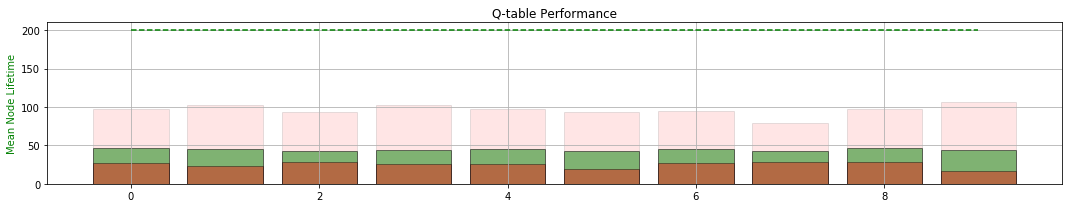

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 130.659	LOSS : 119.727	LOSS : 118.164	LOSS : 105.849	LOSS : 102.886	LOSS : 121.514	LOSS : 100.144	LOSS : 96.267	LOSS : 107.462	LOSS : 99.274	LOSS : 93.129	LOSS : 84.363	LOSS : 86.864	LOSS : 87.117	LOSS : 91.458	LOSS : 88.169	LOSS : 96.716	LOSS : 91.953	LOSS : 88.836	LOSS : 85.962	
Validating... MEAN TIME:  194.765
LOSS : 94.312	LOSS : 81.607	LOSS : 91.197	LOSS : 91.714	LOSS : 88.909	LOSS : 90.144	LOSS : 98.105	LOSS : 96.304	LOSS : 97.132	LOSS : 86.972	LOSS : 86.051	LOSS : 95.113	LOSS : 99.194	LOSS : 98.809	LOSS : 115.902	LOSS : 109.691	LOSS : 101.430	LOSS : 101.065	LOSS : 85.303	LOSS : 97.751	
Validating... MEAN TIME:  146.025
LOSS : 100.089	LOSS : 92.036	LOSS : 109.514	LOSS : 87.445	LOSS : 92.826	LOSS : 98.480	LOSS : 96.998	LOSS : 87.543	LOSS : 86.198	LOSS : 98.177	LOSS : 96.848	LOSS : 122.698	LOSS : 110.636	LOSS : 109.695	LOSS : 106.399	LOSS : 108.888	LOSS : 104.920	LOSS : 98.319	LOSS : 100.260	

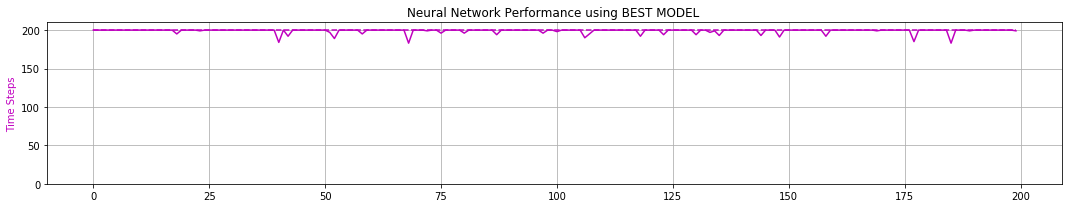

peak memory: 1502.02 MiB, increment: 1027.39 MiB
0 -max- [ 0.139  0.631  0.049  0.556]
0 -min- [-2.393 -3.297 -0.209 -0.920]

1 -max- [ 0.164  0.633  0.051  0.379]
1 -min- [-2.396 -3.446 -0.209 -1.052]

2 -max- [ 0.173  0.628  0.050  0.560]
2 -min- [-2.369 -3.338 -0.209 -0.917]

3 -max- [ 0.148  0.822  0.049  0.373]
3 -min- [-2.389 -3.256 -0.209 -1.176]

4 -max- [ 0.192  0.633  0.050  0.792]
4 -min- [-2.395 -3.313 -0.209 -0.906]

5 -max- [ 0.180  0.744  0.048  0.376]
5 -min- [-2.381 -3.250 -0.209 -1.402]

6 -max- [ 0.156  0.627  0.049  0.600]
6 -min- [-2.371 -3.273 -0.209 -0.921]

7 -max- [ 0.171  0.745  0.050  0.376]
7 -min- [-1.652 -2.742 -0.209 -1.072]

8 -max- [ 0.181  0.632  0.049  0.546]
8 -min- [-2.385 -3.322 -0.209 -0.921]

9 -max- [ 0.178  0.817  0.050  0.376]
9 -min- [-2.385 -3.422 -0.209 -1.224]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   193466
SMALLEST TIMESTEP: 42
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1033865
TOTAL PARALLEL T

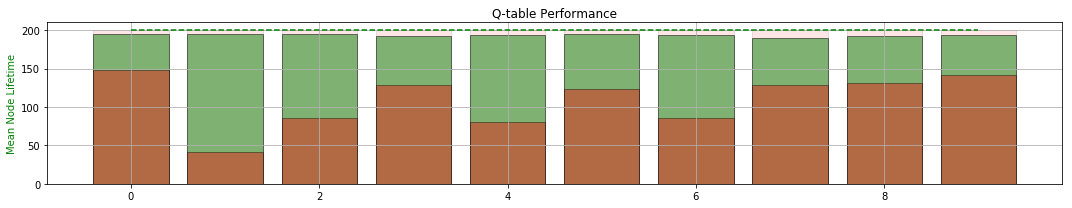

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 83.993	LOSS : 104.470	LOSS : 61.373	LOSS : 62.307	LOSS : 65.797	LOSS : 69.043	LOSS : 51.315	LOSS : 59.057	LOSS : 57.922	LOSS : 57.245	LOSS : 53.247	LOSS : 61.389	LOSS : 56.998	LOSS : 64.488	LOSS : 46.412	LOSS : 49.922	LOSS : 52.704	LOSS : 55.843	LOSS : 59.016	LOSS : 61.354	
Validating... MEAN TIME:  102.095
LOSS : 52.596	LOSS : 61.859	LOSS : 60.677	LOSS : 56.809	LOSS : 55.340	LOSS : 57.026	LOSS : 56.775	LOSS : 55.849	LOSS : 53.523	LOSS : 57.620	LOSS : 50.486	LOSS : 51.916	LOSS : 46.630	LOSS : 59.521	LOSS : 49.668	LOSS : 65.884	LOSS : 57.765	LOSS : 49.550	LOSS : 67.090	LOSS : 63.206	
Validating... MEAN TIME:  67.765
LOSS : 51.748	LOSS : 51.158	LOSS : 60.512	LOSS : 61.502	LOSS : 46.950	LOSS : 61.040	LOSS : 53.851	LOSS : 47.314	LOSS : 53.512	LOSS : 55.231	LOSS : 64.661	LOSS : 53.803	LOSS : 54.336	LOSS : 46.448	LOSS : 60.045	LOSS : 62.164	LOSS : 61.569	LOSS : 59.821	LOSS : 48.341	LOSS : 57.532	
Valida

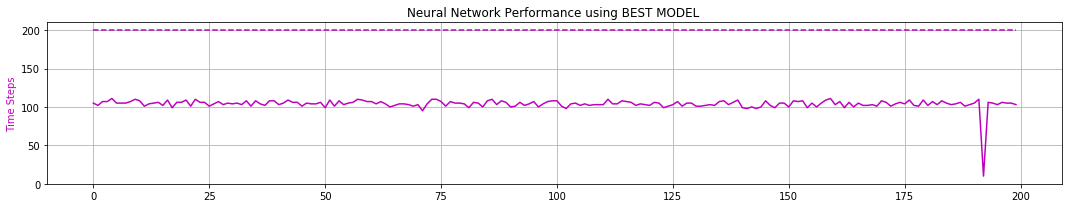

peak memory: 1492.18 MiB, increment: 1017.28 MiB
0 -max- [ 1.176  2.404  0.202  1.329]
0 -min- [-2.399 -2.390 -0.181 -1.176]

1 -max- [ 1.048  2.239  0.176  1.092]
1 -min- [-2.399 -2.252 -0.206 -1.156]

2 -max- [ 1.704  2.556  0.209  1.293]
2 -min- [-2.399 -2.224 -0.186 -1.257]

3 -max- [ 1.210  2.535  0.179  1.237]
3 -min- [-2.399 -2.551 -0.191 -1.157]

4 -max- [ 1.514  2.516  0.208  1.404]
4 -min- [-2.399 -2.259 -0.198 -1.293]

5 -max- [ 0.891  2.180  0.175  1.249]
5 -min- [-2.400 -2.568 -0.205 -1.183]

6 -max- [ 1.511  2.720  0.205  1.357]
6 -min- [-2.400 -2.370 -0.190 -1.118]

7 -max- [ 0.952  2.171  0.178  1.248]
7 -min- [-2.399 -2.375 -0.198 -1.141]

8 -max- [ 1.466  2.418  0.190  1.360]
8 -min- [-2.400 -2.563 -0.193 -1.277]

9 -max- [ 1.114  2.352  0.176  1.148]
9 -min- [-2.400 -2.237 -0.186 -1.168]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   97176
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 118
TOTAL SERIAL TIMESTEPS:   1131041
TOTAL PARALLEL TI

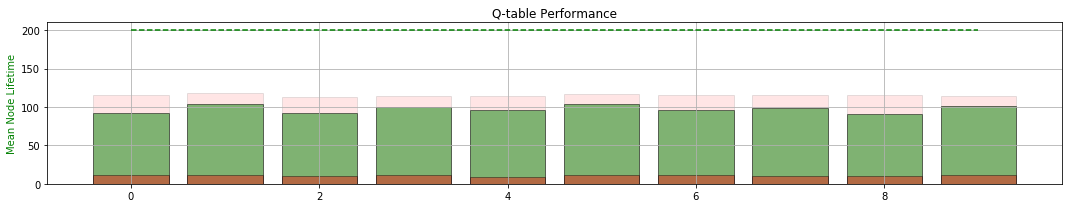

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 84.676	LOSS : 83.697	LOSS : 91.090	LOSS : 96.172	LOSS : 93.160	LOSS : 99.551	LOSS : 103.069	LOSS : 96.766	LOSS : 90.614	LOSS : 82.991	LOSS : 83.421	LOSS : 89.340	LOSS : 75.685	LOSS : 75.126	LOSS : 86.630	LOSS : 92.595	LOSS : 83.307	LOSS : 85.783	LOSS : 83.646	LOSS : 67.359	
Validating... MEAN TIME:  109.855
LOSS : 89.559	LOSS : 85.796	LOSS : 79.639	LOSS : 88.297	LOSS : 78.925	LOSS : 84.334	LOSS : 80.304	LOSS : 89.099	LOSS : 84.009	LOSS : 65.619	LOSS : 69.289	LOSS : 67.126	LOSS : 77.770	LOSS : 80.464	LOSS : 77.702	LOSS : 82.538	LOSS : 79.998	LOSS : 75.521	LOSS : 79.633	LOSS : 71.975	
Validating... MEAN TIME:  199.925
LOSS : 78.335	LOSS : 84.780	LOSS : 75.164	LOSS : 72.178	LOSS : 73.618	LOSS : 75.926	LOSS : 70.421	LOSS : 76.846	LOSS : 73.571	LOSS : 82.334	LOSS : 80.798	LOSS : 68.667	LOSS : 77.511	LOSS : 65.880	LOSS : 72.110	LOSS : 81.274	LOSS : 75.848	LOSS : 64.956	LOSS : 73.465	LOSS : 69.001	
Valid

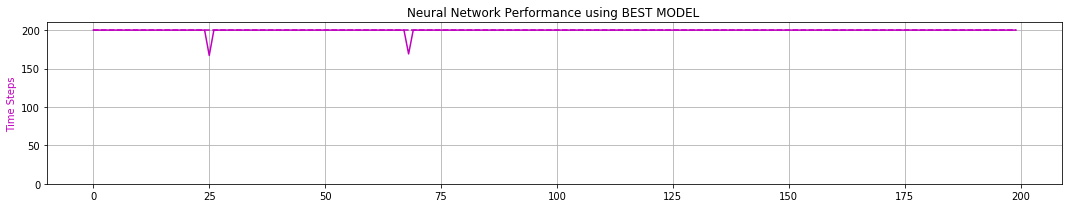

peak memory: 1465.67 MiB, increment: 1017.16 MiB
0 -max- [ 2.400  3.133  0.209  2.064]
0 -min- [-0.201 -1.404 -0.049 -1.463]

1 -max- [ 2.400  2.974  0.207  2.037]
1 -min- [-0.190 -1.403 -0.050 -1.594]

2 -max- [ 2.400  3.175  0.209  2.327]
2 -min- [-0.219 -1.610 -0.049 -1.439]

3 -max- [ 2.400  3.129  0.207  2.337]
3 -min- [-0.200 -1.608 -0.049 -1.475]

4 -max- [ 2.399  3.153  0.209  2.349]
4 -min- [-0.192 -1.607 -0.050 -1.454]

5 -max- [ 2.400  3.101  0.205  2.042]
5 -min- [-0.193 -1.362 -0.049 -1.462]

6 -max- [ 2.400  2.988  0.208  2.321]
6 -min- [-0.181 -1.610 -0.049 -1.395]

7 -max- [ 2.400  3.083  0.208  2.341]
7 -min- [-0.189 -1.609 -0.049 -1.636]

8 -max- [ 2.399  3.110  0.209  2.066]
8 -min- [-0.192 -1.410 -0.050 -1.418]

9 -max- [ 2.400  2.980  0.204  2.055]
9 -min- [-0.210 -1.393 -0.050 -1.531]

Quantization TIME:  0.02 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   197737
SMALLEST TIMESTEP: 134
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1328778
TOTAL PARALLEL

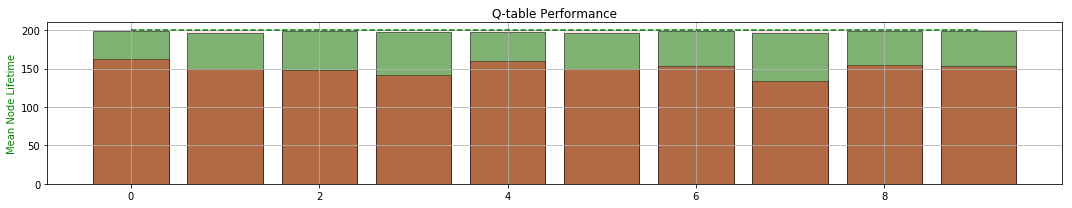

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1971.0
Total Serial Timesteps   :  1328778.0
Speed-up                 :  674.16


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  5987 SUCCESS 134  11    1971    1328778     674.16
